Сироткин Сергей ИУ5-65Б РК2 Вариант 14

In [19]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [20]:
# Загрузка данных
df = pd.read_csv('states_all.csv').iloc[:1500]  

# Удаление лишних
df.drop(columns=['PRIMARY_KEY'], inplace=True, errors='ignore')
df.drop(columns=['AVG_READING_8_SCORE'], inplace=True, errors='ignore')

# Целевая переменная
target_col = 'AVG_MATH_4_SCORE'
if target_col not in df.columns:
    raise ValueError(f"Целевая переменная '{target_col}' отсутствует.")

df = df[df[target_col].notna()]

X = df.drop(columns=[target_col])
y = df[target_col]


In [21]:
# Разделение на категориальные и числовые признаки
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', PCA(n_components=0.95)),  
    ('model', SVR())
])

gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  
    ('model', GradientBoostingRegressor(random_state=42))
])

In [22]:
# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Метод опорных векторов: Подбор гиперпараметров
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto', 0.1, 1],
    'model__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)

# Градиентный бустинг
gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Оценка качества моделей:
Метод опорных векторов: MAE=3.64, RMSE=4.79
Градиентный бустинг: MAE=2.02, RMSE=2.47


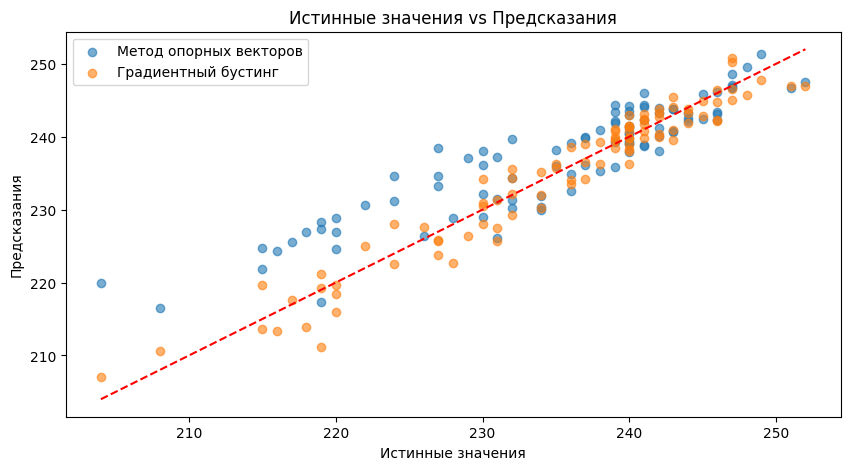

In [23]:
# Оценка качества
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model_name}: MAE={mae:.2f}, RMSE={rmse:.2f}')
    return mae, rmse

print("Оценка качества моделей:")
evaluate_model(y_test, y_pred_svm, "Метод опорных векторов")
evaluate_model(y_test, y_pred_gb, "Градиентный бустинг")

# Визуализация
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_svm, label='Метод опорных векторов', alpha=0.6)
plt.scatter(y_test, y_pred_gb, label='Градиентный бустинг', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.legend()
plt.title('Истинные значения vs Предсказания')
plt.show()

### Классификация или регрессия?
регрессия, потому что предсказываем непрерывную числовую величину - средний балл учащихся по математике в 4-м классе (AVG_MATH_4_SCORE).

### Какие метрики качества использовались и почему? 
Для оценки качества моделей были использованы следующие метрики:

**MAE - средняя абсолютная ошибка**.
Показывает, насколько в среднем предсказание отличается от реального значения.

**RMSE - корень из среднеквадратической ошибки**.
Учитывает большие ошибки сильнее, чем MAE, поэтому позволяет выявить выбросы.

### Метод опорных векторов
- **MAE = 3.64, RMSE = 4.79**
- Модель показала приемлемые результаты после настройки гиперпараметров и уменьшения размерности.
- Однако её точность всё ещё ниже, чем у градиентного бустинга, что связано с чувствительностью Метода опорных векторов к масштабу признаков и сложностям работы с категориальными данными.

### Градиентный бустинг
- **MAE = 2.02, RMSE = 2.47**
- Модель продемонстрировала высокую точность и стабильность.
- Разница между MAE и RMSE небольшая, что указывает на отсутствие значительных выбросов.
- Считается лучшим выбором для прогнозирования среднего балла по математике благодаря своей способности улавливать сложные зависимости в данных.

### Общий вывод:
Градиентный бустинг - более эффективная модель для данной задачи регрессии.  